# Import necessary libraries and Function definition

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

def toYearMonth(date):
    date = pd.to_datetime(date, format='%Y-%m-%d')
    return (date.year, date.month)

def toPreviousMonth(date):
    year, month = date
    if month == 1:
        year, month = year - 1, 12
    else:
        month -= 1
    return (year, month)

def getReturn(column):
    return (column.shift(-1) - column)/column
    
def getLength(column):
    length, maxLength  = 0, 0    
    for data in column:
        if math.isnan(data):
            length = 0
        else:
            length, maxLength = length+1, max(length, maxLength)  
    return maxLength

# Process FED Dataframe

In [2]:
import requests
dictionary = {}
variables = pd.read_csv("FED.csv", header = None).iloc[:,0]
for variable in variables:
    r=requests.get("https://www.quandl.com/api/v3/datasets/FRED/" + variable + "?api_key=xqnYMPynsU15hUaGFvz6")
    df = pd.DataFrame(r.json()['dataset']['data'], columns = ['Date', variable])
    df['YearMonth'] = df['Date'].transform(toYearMonth)
    df.drop('Date', inplace=True, axis=1)
    df.index = df['YearMonth']
    dictionary[variable] = df.groupby(df.index).median().reset_index()

FED = dictionary[variables[0]]
for i in range(len(variables)-1):
    FED = FED.merge(dictionary[variables[i+1]], on = 'YearMonth', how = 'outer')       
FED = FED.sort_values(by='YearMonth')

# Merge SP500 with FED Dataframe

In [3]:
SP500 = pd.DataFrame(pd.read_csv("SP500.Monthly.csv"), columns = ['Date', 'Close'])
SP500['YearMonth'] = SP500['Date'].transform(toYearMonth).transform(toPreviousMonth)
SP500.drop('Date', inplace=True, axis=1)
FED = FED.merge(SP500, on = 'YearMonth', how = 'outer')[:-42].iloc[:,1:].apply(getReturn)[:-1]

# Divide data to train set and test set

In [4]:
for variable in FED:
    if (getLength(FED[variable]) < 800) :
        FED.drop(variable, inplace = True, axis = 1)
    
FED_train = FED[-800:].reset_index(drop = True).iloc[0:600]
FED_test = FED[-800:].reset_index(drop = True).iloc[600:800].reset_index(drop = True)

# Apply  training data to linear regression model

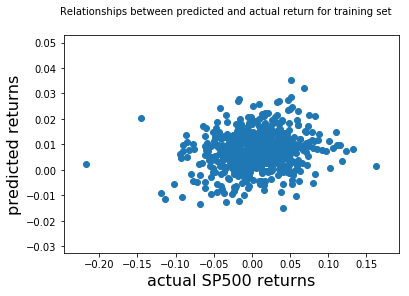

The correlation coefficient between actual and predicted returns in the training set is 0.179870557007


In [5]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(FED_train.drop('Close', inplace = False, axis = 1), FED_train['Close'])

pred = reg.predict(FED_train.drop('Close', inplace = False, axis = 1))
plt.scatter(FED_train['Close'], pred)
plt.suptitle('Relationships between predicted and actual return for training set', fontsize=10)
plt.xlabel('actual SP500 returns', fontsize=16)
plt.ylabel('predicted returns', fontsize=16)
plt.show()
print("The correlation coefficient between actual and predicted returns in the training set is", FED_train['Close'].corr(pd.Series(pred)))

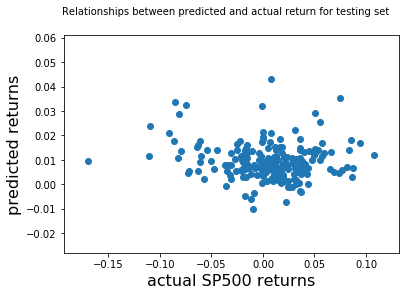

The correlation coefficient between actual and predicted returns in the testing set is -0.118104853624


In [6]:
pred = reg.predict(FED_test.drop('Close', inplace = False, axis = 1))
plt.scatter(FED_test['Close'], pred)
plt.suptitle('Relationships between predicted and actual return for testing set', fontsize=10)
plt.xlabel('actual SP500 returns', fontsize=16)
plt.ylabel('predicted returns', fontsize=16)
plt.show()
print("The correlation coefficient between actual and predicted returns in the testing set is", FED_test['Close'].corr(pd.Series(pred)))

Because of the small correlation between the predictions and actual data, I don't think the model is suitable for making buy/sell decisions. There're several reasons for it:

1. Since we've used eight finanical variables, they may be correlated with each other. 
2. Since we use a linear model, maybe we are underffiting the model.
3. The market is effective, hence we can't infer the 'close' from past data.